# Towards Automated GDPR-compliance in Organizations: A Natural Language Processing Based Machine Learning Approach

# 1. Classification and Calibration

This script includes a supervised machine learning-based NLP pipeline to build five classifiers that can assess whether privacy policies disclose the five GDPR privacy policy core requirements. It was hypothesized that integrating NLP in our approach was essential since privacy policies are expressed in natural language. The dataset for training the models was acquired from [1] containing 250 anonymized privacy policies comprising over 18,300 natural sentences labeled according to the five GDPR privacy policy core requirements in the Table 1. Our approach resulted in five different classification models—trained using Python's Scikit-Learn library—each focusing on one of the GDPR privacy policy core requirements.


|No.|	Requirement|Required content in privacy policy|
|:---:|:---|:---|
|1| DPO | Contact details for the data protection officer or equivalent |
|2| Purpose | Disclosure of the purpose for which personal data is or is not used for |
|3| Acquired data | Disclosure that personal data is or is not collected, and/or which data is collected |
|4| Data sharing | Disclosure if 3rd parties can or cannot access a user’s personal data |
|5| Rights | Disclosure of the user’s right to rectify or erase personal data |

<center>Table 1: Five GDPR Privacy Policy Core Requirements</center>

#### Data set
This manually labeled data set [1] comprises 250 individual policies, containing over 18,300 natural sentences. The data is labeled according to the GDPR privacy policy key requirements as presented in Table 1. The data can be accessed via this link: https://git.aisec.fraunhofer.de/projects/GDPRCOM/repos/on-gdpr-compliance/browse.

---
#### References
[1] Müller, Nicolas M., et al. "On GDPR compliance of companies’ privacy policies." International Conference on Text, Speech, and Dialogue. Springer, Cham, 2019.

#### Libraries

In [63]:
from platform import python_version
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from nltk.stem import PorterStemmer
# from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from imblearn.over_sampling import RandomOverSampler
from time import time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, f1_score, accuracy_score, recall_score, average_precision_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import pickle
from shapely.geometry import LineString
import array as arr
import matplotlib.pyplot as plt  
from scipy.stats import binom
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from imblearn.pipeline import Pipeline as ILPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [57]:
from sklearn.metrics import plot_roc_curve

ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (C:\Users\aaberkan\Anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [3]:
print(python_version())

3.8.5


---

## Import data: 18.397 labeled sentence snippets

In [6]:
DATA_FILE = "data/GDPR.csv"

In [8]:
dataset = pandas.read_csv(DATA_FILE, sep='\t', encoding='utf-8')
print(dataset.shape)

(18397, 6)


### Explore balance of dataset

Text(0.5, 0, 'GDPR Assessment Criteria')

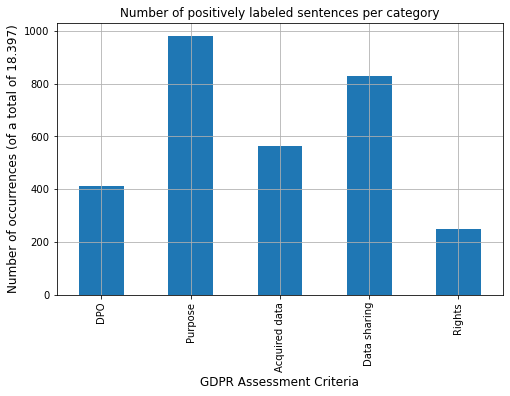

In [27]:
categories = list(dataset.columns)[1:] # select all except 'text' column

counts = []
for column in categ:
    counts.append((column, dataset[column].value_counts()[1]))

df_stats = pandas.DataFrame(counts, columns=['GDPR_criteria', 'number_of_pos_sen'])

df_stats.plot(x='GDPR_criteria', y='number_of_pos_sen', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of positively labeled sentences per category")
plt.ylabel('Number of occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('GDPR Assessment Criteria', fontsize=12)

### Explore number of multi-labeled sentences
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

C:\Users\aaberkan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Number GDPR criteria per sentence')

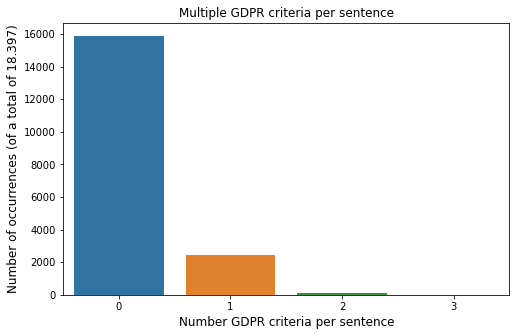

In [10]:
rowsums = dataset.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple GDPR criteria per sentence")
plt.ylabel('Number of occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('Number GDPR criteria per sentence', fontsize=12)

###### Note: the vast majority of the sentences is not labeled at all (almost 16.000)
The problem of class imbalance shall be addressed below.

---

## Preprocessing

The preprocessing consists of the following steps: 
- addressing the class imbalance by oversampling the minority class in the training set;
- removing punctuation;
- removing words containing digits (authors of data set used these words to scramble the data, e.g., company_32782);
- removing stopwords;
- stemming;

Lastly, we also conduct a stratified split on the data set to address the class imbalance, and introduce a method to oversample the minority class in the training set later on. 

In [170]:
# This method executes the previously mentioned preprocessing tasks.
# It takes a list of sentences as an argument and returns a list of preprocessed sentences.
def preprocessing(pps):
#     tokenizer = nlp.tokenizer
    # tokenize sentences
    tokenized_sent = [sent.split() for sent in pps]
    
    # remove punctuation
    tokenized_sent = [[re.sub('[,’\'\.!?&“”():*_;"]', '', y) for y in x] for x in tokenized_sent]
    
    # remove words with digits
    tokenized_sent = [[y for y in x if not any(c.isdigit() for c in y)] for x in tokenized_sent]
    
    # remove stopwords   
    tokenized_sent_clean = tokenized_sent
#     tokenized_sent_clean = [[y for y in x if y not in stopwords.words('english')] for x in tokenized_sent]
    
    # from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    tokenized_sent_clean = [[porter.stem(y) for y in x] for x in tokenized_sent_clean]
    
#     lemmatizer = WordNetLemmatizer()
#     tokenized_sent_clean = [[lemmatizer.lemmatize(y) for y in x] for x in tokenized_sent_clean]

    detokenized_pps = []
    for i in range(len(tokenized_sent_clean)):
        t = ' '.join(tokenized_sent_clean[i])
        detokenized_pps.append(t) 
    
    return detokenized_pps

### Gridsearch

In [167]:
def make_and_train_pipeline(
    X, y,
    transformer = True,
    sampler = True,
    classifier = True,
):

    if transformer is True: transformer = TfidfTransformer
    if sampler is True: sampler = RandomOverSampler
    if classifier is True: classifier = LogisticRegression
    
#     steps = [("vec", CountVectorizer())]
    steps = [("tfidf", TfidfVectorizer())]
#     steps = []
#     if transformer: steps += [("tra", transformer())]
    if sampler: steps += [("sam", sampler(random_state = 42))]
    if classifier is ClassifierChain:
        steps += [("cla", classifier(LogisticRegression()))]
    elif classifier: steps += [("cla", classifier())]
    
    pipeline = ILPipeline(steps)

    parameters = {
#         "vec__stop_words": ("english",),
#         "vec__max_df": (0.1, 0.4, 0.5, 0.6, 1.0),
#         'vec__max_features': (500, 1000, 2000, 5000),
#         "vec__ngram_range": ((1, 1), (1, 2), (1, 3)),
#         "tfidf__max_df": (0.1, 0.4, 0.5, 0.6, 1.0),
        "tfidf__max_features": (500, 1000, 2000, 5000),
        "tfidf__ngram_range": ((1, 1), (1, 2), (1, 3)),
#         "tra__use_idf": (True,),
#         "tra__norm": ("l2",)
    }
    if classifier is LogisticRegression:
        parameters.update({
            "cla__C": (0.1, 0.01, 0.001, 0.0001),
#             "cla__penalty": ("l2",),
#             "cla__solver": ("lbfgs",),
            'cla__max_iter': (200,)
        })
    if classifier is RandomForestClassifier:
        parameters.update({
            "cla__max_features": ("sqrt",),
            "cla__n_estimators": (500,),
        })

    grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, verbose=4, scoring="roc_auc")
    grid_search.fit(X, y)

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    return grid_search

In [236]:
def plot_results(y, preds):
    print(f" \
        {roc_auc_score(y, preds >= .5) = }\n \
        {accuracy_score(y, preds >= .5) = }\n \
        {recall_score(y, preds >= .5) = }\n \
        {precision_score(y, preds >= .5) = }"
    )
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(np.arange(0, .8, 0.01), [roc_auc_score(y, preds >= t) for t in np.arange(0, .8, 0.01)])
    ax1.plot(np.arange(0, .8, 0.01), [recall_score(y, preds >= t) for t in np.arange(0, .8, 0.01)])
    ax1.plot(np.arange(0, .8, 0.01), [precision_score(y, preds >= t) for t in np.arange(0, .8, 0.01)])
    ax1.plot(np.arange(0, .8, 0.01), [accuracy_score(y, preds >= t) for t in np.arange(0, .8, 0.01)])
    ax1.legend(labels=["ROC", "recall", "precision", "accuracy"])
    RocCurveDisplay.from_predictions(y, preds, ax=ax2)
    plt.show()

DPO
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.981
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
         f1_score(y, preds >= .5) = 0.5584045584045585
         accuracy_score(y, preds >= .5) = 0.966304347826087
         recall_score(y, preds >= .5) = 0.9423076923076923
         precision_score(y, preds >= .5) = 0.3967611336032389


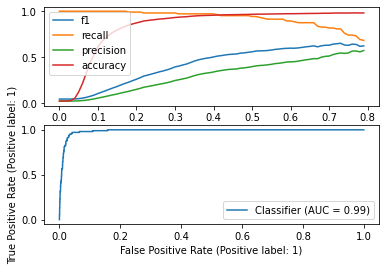

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.980
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 3)
         f1_score(y, preds >= .5) = 0.5289256198347108
         accuracy_score(y, preds >= .5) = 0.9628260869565217
         recall_score(y, preds >= .5) = 0.9230769230769231
         precision_score(y, preds >= .5) = 0.37065637065637064


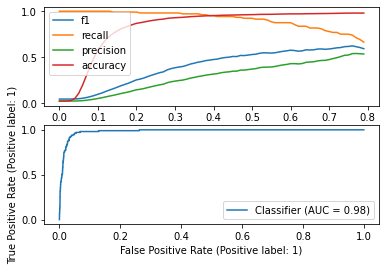


--- --- --- --- --- --- --- --- --- ---
Purpose
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.928
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
         f1_score(y, preds >= .5) = 0.4539170506912443
         accuracy_score(y, preds >= .5) = 0.8969565217391304
         recall_score(y, preds >= .5) = 0.8040816326530612
         precision_score(y, preds >= .5) = 0.3162118780096308


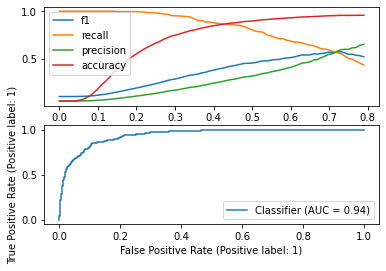

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.930
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
         f1_score(y, preds >= .5) = 0.4506387921022068
         accuracy_score(y, preds >= .5) = 0.8971739130434783
         recall_score(y, preds >= .5) = 0.7918367346938775
         precision_score(y, preds >= .5) = 0.31493506493506496


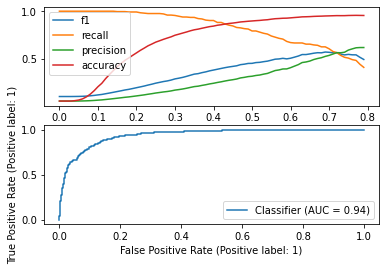


--- --- --- --- --- --- --- --- --- ---
Acquired data
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.946
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
         f1_score(y, preds >= .5) = 0.4632516703786191
         accuracy_score(y, preds >= .5) = 0.9476086956521739
         recall_score(y, preds >= .5) = 0.7375886524822695
         precision_score(y, preds >= .5) = 0.33766233766233766


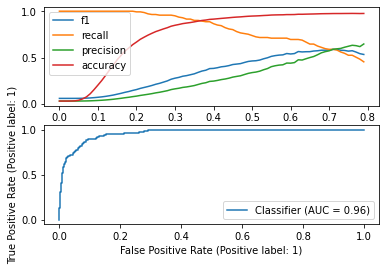

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.952
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 3)
         f1_score(y, preds >= .5) = 0.4543524416135881
         accuracy_score(y, preds >= .5) = 0.9441304347826087
         recall_score(y, preds >= .5) = 0.7588652482269503
         precision_score(y, preds >= .5) = 0.3242424242424242


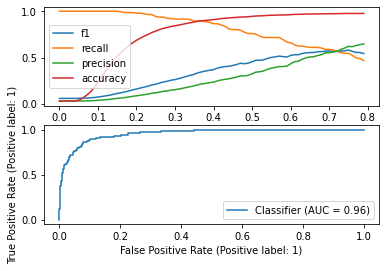


--- --- --- --- --- --- --- --- --- ---
Data sharing
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.977
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
         f1_score(y, preds >= .5) = 0.6037099494097807
         accuracy_score(y, preds >= .5) = 0.9489130434782609
         recall_score(y, preds >= .5) = 0.8605769230769231
         precision_score(y, preds >= .5) = 0.4649350649350649


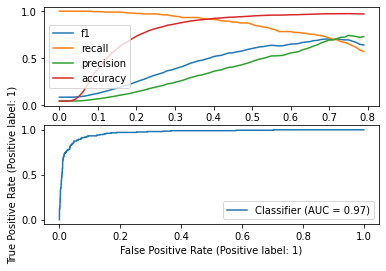

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.978
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
         f1_score(y, preds >= .5) = 0.6056572379367721
         accuracy_score(y, preds >= .5) = 0.9484782608695652
         recall_score(y, preds >= .5) = 0.875
         precision_score(y, preds >= .5) = 0.4631043256997455


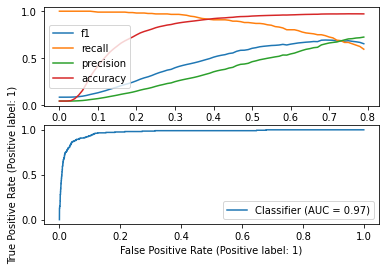


--- --- --- --- --- --- --- --- --- ---
Rights
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.993
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 2000
	tfidf__ngram_range: (1, 1)
         f1_score(y, preds >= .5) = 0.495798319327731
         accuracy_score(y, preds >= .5) = 0.9739130434782609
         recall_score(y, preds >= .5) = 0.9365079365079365
         precision_score(y, preds >= .5) = 0.33714285714285713


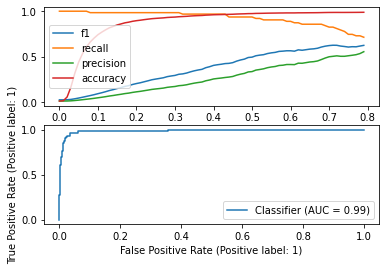

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.995
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 2000
	tfidf__ngram_range: (1, 1)
         f1_score(y, preds >= .5) = 0.5345622119815667
         accuracy_score(y, preds >= .5) = 0.9780434782608696
         recall_score(y, preds >= .5) = 0.9206349206349206
         precision_score(y, preds >= .5) = 0.37662337662337664


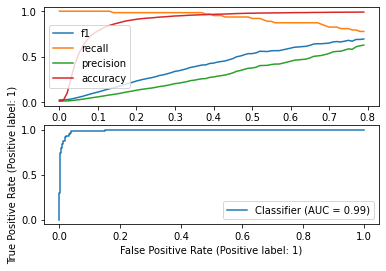


--- --- --- --- --- --- --- --- --- ---


In [171]:
for i, category in enumerate(categories):
    print(category)
    train, test = train_test_split(dataset, stratify=dataset[category], random_state=42)
    y_train, y_test = train[category], test[category]
    lr_model = make_and_train_pipeline(train.Text, y_train)
    plot_results(y_test, lr_model.predict_proba(test.Text)[:, 1])
    
    print("Same category with preprocessing: ")
    prep_train_text, prep_test_text = preprocessing(train.Text), preprocessing(test.Text)
    lr_model = make_and_train_pipeline(prep_train_text, y_train)
    plot_results(y_test, lr_model.predict_proba(prep_test_text)[:, 1])
    print()
    print("--- --- --- --- --- --- --- --- --- ---")

DPO
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.981
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 1)
         f1_score(y, preds >= .5) = 0.45333333333333325
         accuracy_score(y, preds >= .5) = 0.9554347826086956
         recall_score(y, preds >= .5) = 0.8192771084337349
         precision_score(y, preds >= .5) = 0.31336405529953915


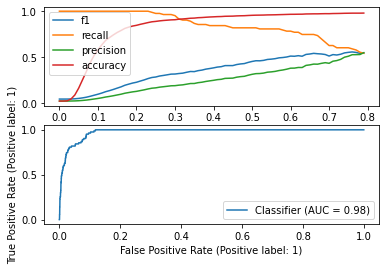

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.980
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 2000
	tfidf__ngram_range: (1, 2)
         f1_score(y, preds >= .5) = 0.46689895470383275
         accuracy_score(y, preds >= .5) = 0.9584239130434783
         recall_score(y, preds >= .5) = 0.8072289156626506
         precision_score(y, preds >= .5) = 0.3284313725490196


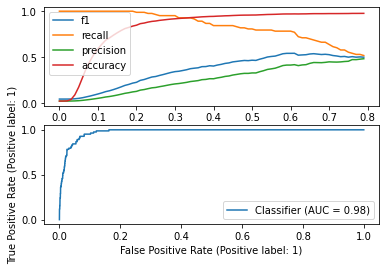


--- --- --- --- --- --- --- --- --- ---
Purpose
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.931
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
         f1_score(y, preds >= .5) = 0.43815201192250364
         accuracy_score(y, preds >= .5) = 0.897554347826087
         recall_score(y, preds >= .5) = 0.75
         precision_score(y, preds >= .5) = 0.3094736842105263


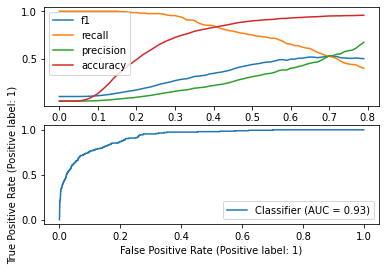

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.934
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 3)
         f1_score(y, preds >= .5) = 0.4447761194029851
         accuracy_score(y, preds >= .5) = 0.8989130434782608
         recall_score(y, preds >= .5) = 0.7602040816326531
         precision_score(y, preds >= .5) = 0.3143459915611814


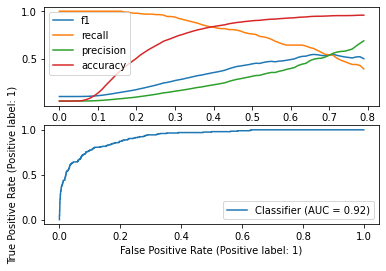


--- --- --- --- --- --- --- --- --- ---
Acquired data
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.944
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 3)
         f1_score(y, preds >= .5) = 0.46022727272727276
         accuracy_score(y, preds >= .5) = 0.9483695652173914
         recall_score(y, preds >= .5) = 0.7168141592920354
         precision_score(y, preds >= .5) = 0.3389121338912134


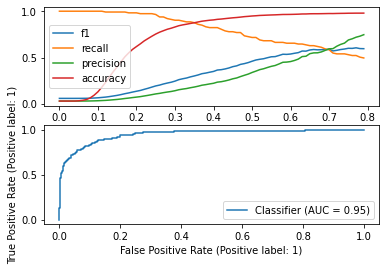

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.948
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 3)
         f1_score(y, preds >= .5) = 0.47486033519553067
         accuracy_score(y, preds >= .5) = 0.9489130434782609
         recall_score(y, preds >= .5) = 0.7522123893805309
         precision_score(y, preds >= .5) = 0.3469387755102041


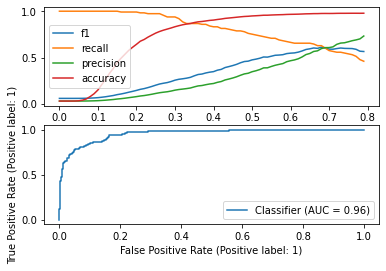


--- --- --- --- --- --- --- --- --- ---
Data sharing
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.975
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 2)
         f1_score(y, preds >= .5) = 0.6318082788671023
         accuracy_score(y, preds >= .5) = 0.9540760869565217
         recall_score(y, preds >= .5) = 0.8734939759036144
         precision_score(y, preds >= .5) = 0.4948805460750853


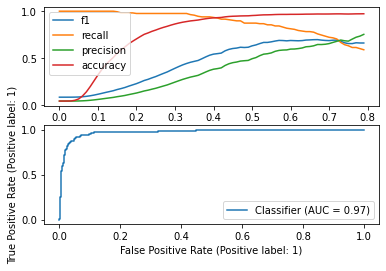

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.976
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 5000
	tfidf__ngram_range: (1, 1)
         f1_score(y, preds >= .5) = 0.6124999999999999
         accuracy_score(y, preds >= .5) = 0.9494565217391304
         recall_score(y, preds >= .5) = 0.8855421686746988
         precision_score(y, preds >= .5) = 0.4681528662420382


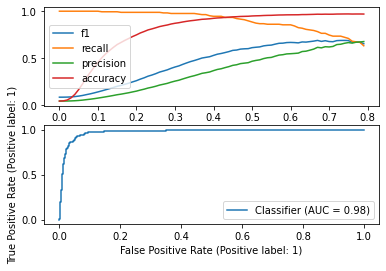


--- --- --- --- --- --- --- --- --- ---
Rights
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.992
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 2000
	tfidf__ngram_range: (1, 1)
         f1_score(y, preds >= .5) = 0.5294117647058825
         accuracy_score(y, preds >= .5) = 0.9782608695652174
         recall_score(y, preds >= .5) = 0.9
         precision_score(y, preds >= .5) = 0.375


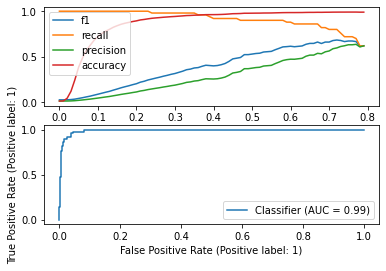

Same category with preprocessing: 
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.994
Best parameters set:
	cla__C: 0.1
	cla__max_iter: 200
	tfidf__max_features: 2000
	tfidf__ngram_range: (1, 1)
         f1_score(y, preds >= .5) = 0.5962732919254659
         accuracy_score(y, preds >= .5) = 0.9823369565217391
         recall_score(y, preds >= .5) = 0.96
         precision_score(y, preds >= .5) = 0.43243243243243246


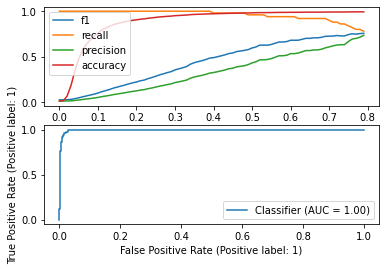


--- --- --- --- --- --- --- --- --- ---


In [203]:
for i, category in enumerate(categories):
    print(category)
    train, test = train_test_split(dataset, stratify=dataset[category], random_state=42, test_size = 0.2)
    train, val = train_test_split(train, stratify=train[category], random_state=42, test_size = 0.25)
#     test = 0.2
#     val = 0.25 * 0.8 = 0.2
#     train = 0.8*0.75 = 0.6
    y_train, y_val = train[category], val[category]
    lr_model = make_and_train_pipeline(train.Text, y_train)
    plot_results(y_val, lr_model.predict_proba(val.Text)[:, 1])
    
    print("Same category with preprocessing: ")
    prep_train_text, prep_val_text = preprocessing(train.Text), preprocessing(val.Text)
    lr_model = make_and_train_pipeline(prep_train_text, y_train)
    plot_results(y_val, lr_model.predict_proba(prep_val_text)[:, 1])
    print()
    print("--- --- --- --- --- --- --- --- --- ---")

# Predict & Evaluate

We use the optimized parameters to build classification models. These confusion matrix of the test set (using these classification models) is then computed based on the ideal threshold/cutoff value, that corresponds with the highest F1-score.

In [231]:
def cutoff_results_f1(y_test, y_prob):
    # Let's create columns with different probability cutoffs 
    thresholds = [float(x)/50 for x in range(50)]
    f1_list = []
    
    for i in thresholds:
        y_pred_o = np.where(y_prob > i, 1, 0)
        f1_list.append(f1_score(y_test, y_pred_o))

    max_f1 = max(f1_list)
    print(f"Max F1-score: {max_f1}")
    max_index = f1_list.index(max_f1)
    y_pred_max = np.where(y_prob > thresholds[max_index], 1, 0)

    return f1_list, thresholds, y_pred_max

In [226]:
def plot_f1_threshold(y_test, y_prob):
    f1_list, thresholds, y_pred_max = cutoff_results_f1(y_test, y_prob)
    plt.plot(thresholds, f1_list, label = "f1-score")
    plt.legend()
    plt.xlabel('Treshold')
    plt.ylabel('F1-score')
    plt.title('F1-score Performance: '+ category)
    plt.show()
    return y_pred_max

In [193]:
# Oversamples the minority class using the RandomOverSampler class
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
def oversample_data(x, y):    
#     oversample = RandomOverSampler(sampling_strategy='minority', random_state = 42)
    oversample = RandomOverSampler(random_state = 42)
    x_over, y_over = oversample.fit_resample(x, y)
    return x_over, y_over

In [229]:
def print_important_features(vectorizer, lr):
    print("Most important features:")
    words = vectorizer.get_feature_names_out()
    for label, coefs, intercept in zip(lr.classes_, lr.coef_, lr.intercept_):
        print(label)
        sort_zipped_list = sorted(zip(words, coefs), key = lambda x: x[1], reverse = True) 
        for t, c in list(sort_zipped_list)[:10]:
            print(t, c)
        print("...")
        print("INTERCEPT:" +str(intercept))
        print("...")
        for t, c in list(sort_zipped_list)[-10:]:
            print(t, c)
        print()

Using optimized parameters

In [204]:
ngrams = [(1,1), (1,3), (1,3), (1,1), (1,1)]
max_iter = 200
C = 0.1
max_features_r = [5000, 5000, 5000, 5000, 2000]
preprocessing_r = [False, True, True, True, True]

DPO
Most important features:
0
domain 6.581848695684674
please 4.26631524608571
contact 3.86100013306056
officer 3.6497710609513057
at 3.2652392923205547
protection 3.1197432381171724
ico 3.091260549474913
email 3.0650507126192856
questions 2.664761306906191
office 2.6207101989400945
...
INTERCEPT:-2.285046183919187
...
when -1.0289301111790135
provide -1.058230302032556
services -1.11840162472061
other -1.1297258209483816
not -1.206123752793744
we -1.251605313188329
cookies -1.2634234431353861
will -1.3476342627318527
that -1.5568652682151156
and -1.852248176232425

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3597
           1       0.34      0.92      0.50        83

    accuracy                           0.96      3680
   macro avg       0.67      0.94      0.74      3680
weighted avg       0.98      0.96      0.97      3680

ROC AUC: 0.9373976305555833
Confusion matrix DPO:
[[3450  147]
 [   7   76]]
Confusion matrix after

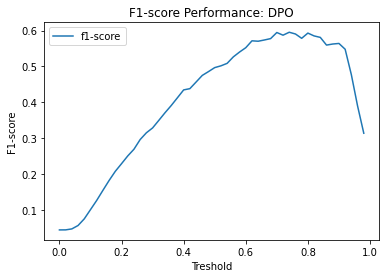

[[3529   68]
 [  19   64]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 

Purpose
Most important features:
0
to 3.1733345872481555
purpos 3.0114338218801255
use 2.9130249178665375
and 2.3757810635331613
use your 2.3438860831263817
for 2.2199019438018506
you 2.0763388343825935
servic 2.0135654950547206
inform to 1.9214437154651332
use your person 1.7872552098061107
...
INTERCEPT:-1.800278428005637
...
right to -0.8671511999523965
not -0.8683257353718337
pleas -0.8982799789634615
access -0.9120560748219997
if -0.9174588381673277
to the -0.9228656728991999
how -1.0830583106958864
privaci -1.093903505907612
right -1.1851051992300765
cooki -1.7005970579281349

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3484
           1       0.32      0.76      0.45       196

    accuracy                           0.90      3680
   macro avg       0.65      0.83      0.70      3680
weighted avg       0.95      0.90      0.92      3680

ROC A

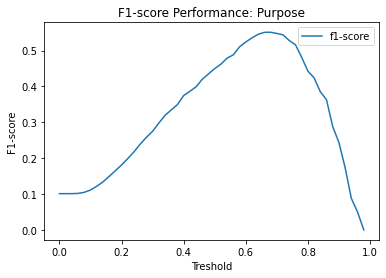

[[3383  101]
 [  83  113]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 

Acquired data
Most important features:
0
collect 4.214516371034377
name 3.6950480657473213
address 3.0991671842998265
detail 3.067938374176069
includ 2.6234854230723927
photograph 2.559716135468022
record 2.4597778349492043
we collect 2.254505177185943
health 2.195148901926697
ident 2.073169437438149
...
INTERCEPT:-1.7528254181911753
...
cooki -0.8904259737483934
it -0.8953864095071328
to -0.897530836650416
privaci -0.9391498770314213
your person -0.9699682597191543
access -0.9999490319811589
the -1.13047325862383
how -1.13899438205063
right -1.1403766244917846
share -1.1439655877043922

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3567
           1       0.32      0.73      0.45       113

    accuracy                           0.94      3680
   macro avg       0.66      0.84      0.71      3680
weighted avg       0.97      0.94      0.95      3680



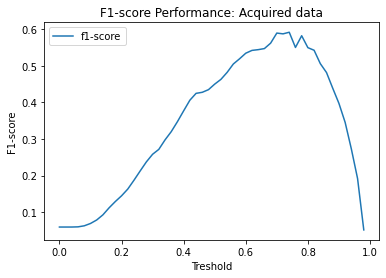

[[3530   37]
 [  50   63]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 

Data sharing
Most important features:
0
share 6.310626375472725
disclos 4.706516841605174
parti 4.194735563924163
third 3.917603349980146
transfer 3.169116998381212
with 2.8409359062807904
pass 2.760519913384826
outsid 2.6808173135202646
may 2.36563427359771
sell 2.3534820133435246
...
INTERCEPT:-2.703104831849879
...
thi -0.9208675243930378
account -0.9415762386037267
how -0.993222067292561
from -1.0158414238332774
collect -1.246368672437414
right -1.336349880511876
websit -1.483013778478821
cooki -1.5194878833263163
use -2.3853516525188163
you -2.4715780055378627

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3514
           1       0.42      0.87      0.57       166

    accuracy                           0.94      3680
   macro avg       0.71      0.91      0.77      3680
weighted avg       0.97      0.94      0.95      3680

ROC AUC: 0.90584649354

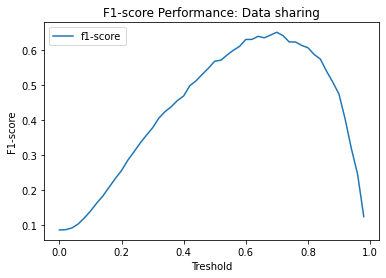

[[3434   80]
 [  47  119]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 

Rights
Most important features:
0
delet 5.158422954894296
erasur 4.913983445593973
correct 4.869817757857577
remov 4.518755507725234
right 4.189416210594897
eras 3.520212650959815
request 3.2246141641979724
forgotten 3.156638371787682
rectifi 3.0881655840218114
updat 3.0579835995674545
...
INTERCEPT:-3.12043877308624
...
polici -0.9055600369887575
for -0.9580706207118248
cooki -0.9859020921697648
privaci -1.0223185269394923
may -1.0228257118409407
collect -1.0306193227336997
websit -1.1117263318856518
other -1.1242114079899814
servic -1.229032704617564
are -1.33329797538144

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3630
           1       0.36      0.94      0.52        50

    accuracy                           0.98      3680
   macro avg       0.68      0.96      0.75      3680
weighted avg       0.99      0.98      0.98      3680

ROC AUC: 0.95

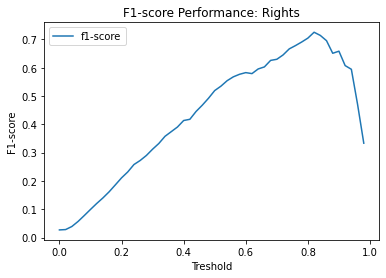

[[3615   15]
 [  13   37]]
--- --- --- --- --- --- 
--- --- --- --- --- --- 



In [237]:
for i, category in enumerate(categories):
    print(category)
    train, test = train_test_split(dataset, stratify=dataset[category], random_state=42, test_size = 0.2)
    train, val = train_test_split(train, stratify=train[category], random_state=42, test_size = 0.25)
    x_train, x_test = train.Text, test.Text
    y_train, y_test = train[category], test[category]
    
    vectorizer = TfidfVectorizer(
        ngram_range = ngrams[i],
        max_features = max_features_r[i])
    
    if preprocessing_r[i]:
        x_train = preprocessing(x_train)
        x_test = preprocessing(x_test)

    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)

    x_train, y_train = oversample_data(x_train, y_train)
    
    lr = LogisticRegression(max_iter = max_iter, C = C)
    lr.fit(x_train, y_train)
    
    print_important_features(vectorizer, lr)
    
    y_pred = lr.predict(x_test)
    y_prob = lr.predict_proba(x_test)[:,1]
    
    print(classification_report(y_test, y_pred))
    print("ROC AUC: " + str(roc_auc_score(y_test, y_pred)))
    
    print("Confusion matrix " + category + ":")
    print(confusion_matrix(y_test, y_pred))

    
    print("Confusion matrix after thresholding " + category + ":")
    y_cutoff = plot_f1_threshold(y_test, y_prob)
    print(confusion_matrix(y_test, y_cutoff))
    print("--- --- --- --- --- --- ")
    print("--- --- --- --- --- --- ")
    print()

---

# Retrain on whole data set

In [233]:
ngrams = [(1,1), (1,3), (1,3), (1,1), (1,1)]
max_iter = 200
C = 0.1
max_features_r = [5000, 5000, 5000, 5000, 2000]
preprocessing_r = [False, True, True, True, True]

In [234]:
for i, category in enumerate(categories):
    X, y = dataset.Text, dataset[category]
    
    vectorizer = TfidfVectorizer(
        ngram_range = ngrams[i],
        max_features = max_features_r[i])
    
    if preprocessing_r[i]: X = preprocessing(X);

    X = vectorizer.fit_transform(X)

    X, y = oversample_data(X, y)
    
    lr = LogisticRegression(max_iter = max_iter, C = C)
    lr.fit(X, y)
    
    # Save to file in the current working directory
    lr_file = "linreg-oversampling-" + category + ".pkl"
    with open(lr_file, 'wb') as file:
        pickle.dump((vectorizer, lr), file)

---

# Increase Certainty of Predictions
The classification results lead to the following question: __When does a privacy policy as a whole meet the GDPR privacy policy core requirement at issue?__ Is the mere presence of one positively classified sentence enough to consider the whole privacy policy compliant with the GDPR class in question? In this research, we decided to raise the certainty of our predictions by addressing the following question: __What number of positive sentences are needed to classify, with a desired level of confidence, a new privacy policy as compliant with the requirement at issue?__ To address this question, we exert the inverse cumulative distribution function of the binomial distribution to set a threshold of the minimum positive sentences required to meet a given confidence level. This step is necessary since our classification models work at the sentence-level rather than at the document-level due to the data set used to train the models. This data set consists of labeled sentences extracted from privacy policies without insight into the structure of the original documents (i.e., privacy policies).

Given a contingency table consisting of true positive (TP), false positive (FP), true negative (TN), and false negative (FN) values, based on a data set comprising, in total, E = TP + FP + TN + FN elements—$\hat{P}$ describes the elements predicted as positive, i.e., $\hat{P}$ = TP + FP. The probability that a positively predicted element is a true positive can then be described as $P(y=1|\hat{y}=1) = \frac{TP}{\hat{P}}$. Using a binomial distribution, the probability that exactly $k$ elements from $\hat{P}$ are true positives can be calculated as follows:

\begin{equation}
      P(|TP| = k) = \binom{\hat{P}}{k} P(y=1|\hat{y}=1)^k (1 - P(y=1|\hat{y}=1))^{\hat{P}-k} 
      = \binom{\hat{P}}{k} P_{TP}^k P_{FP}^{\hat{P}-k}
\end{equation}

It follows that the cumulative distribution function is equal to:

\begin{equation}
      P(|TP| \leq k) = \sum_{i=0}^k \binom{\hat{P}}{i} P_{TP}^k P_{FP}^{\hat{P}-i}
\end{equation}

We focus on the probability that the number of TP exceeds a given value, therefore we consider the inverse cumulative distribution:

\begin{equation}
      P(|TP| > k) = 1 - P(|TP| \leq k) = 1 - \sum_{i=0}^k \binom{\hat{P}}{i} P_{TP}^k P_{FP}^{\hat{P}-i}
\end{equation}

We now find the highest value of $k$ (i.e., $k'$) that keeps the inverse cumulative distribution above a given desired probability $Z$:

\begin{equation}
    k' = argmax_{k\in[0,|TP|]} P(|TP| > k) \geq Z
\end{equation} 

Given a new set of elements (e.g., sentences in a privacy policy) with $E_n$ elements of which $\hat{P}_n$ are predicted as positive by the model. We consider the document to be positive if the threshold, ${Q}=\frac{k'}{E}$ is met, i.e., $\frac{\hat{P}}{E_n} \geq Q$.

### Example: label = DPO

|DPO (3548N, 132P)| Predicted N | Predicted P |
|:---:|:---:|:---:|
| Actual N | TN = 3529 | FP = 68 |
| Actual P | FN = 19 | TP = 64 |

* ${E}$ = TP + FP + TN + FN = 64 + 68 + 3529 + 19 = 3680 <br>
* $\hat{P}$ = TP + FP = 64 + 68 = 132 <br>
* $P(y=1|\hat{y}=1) = \frac{TP}{\hat{P}} = \frac{64}{132}$.

#### Binomial Distribution
Using a binomial distribution, the probability that exactly $k$ elements from $\hat{P}$ are true positives can be calculated as follows:

\begin{equation}
      P(|TP| = k) = \binom{\hat{P}}{k} P(y=1|\hat{y}=1)^k (1 - P(y=1|\hat{y}=1))^{\hat{P}-k} 
      = \binom{\hat{P}}{k} P_{TP}^k P_{FP}^{\hat{P}-k}
\end{equation}

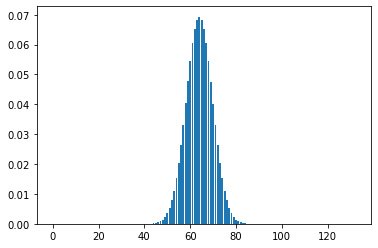

In [206]:
# setting the values of n and p
n = 132
k = 132
p = (64/132)

# defining list of r values
r_values = list(range(k + 1))

# list of pmf values
dist = [binom.pmf(r, n, p) for r in r_values ]

# plotting the graph 
plt.bar(r_values, dist)
plt.show()

#### Cumulative Binomial Distribution
It follows that the cumulative distribution function is equal to:

\begin{equation}
      P(|TP| \leq k) = \sum_{i=0}^k \binom{\hat{P}}{i} P_{TP}^k P_{FP}^{\hat{P}-i}
\end{equation}

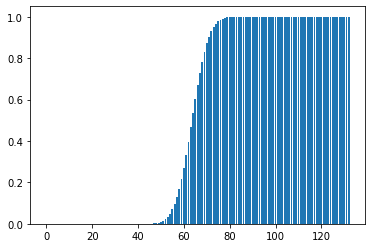

In [207]:
n = 132
k = 132
p = (64/132)

# defining list of r values
r_values = list(range(k + 1))

# list of pmf values
dist = [binom.cdf(r, n, p) for r in r_values ]

# plotting the graph 
plt.bar(r_values, dist)
plt.show()

#### Cumulative Binomial Distribution: step 1

We focus on the probability that the number of TP exceeds a given value, therefore we consider the inverse cumulative distribution:

\begin{equation}
      P(|TP| > k) = 1 - P(|TP| \leq k) = 1 - \sum_{i=0}^k \binom{\hat{P}}{i} P_{TP}^k P_{FP}^{\hat{P}-i}
\end{equation}

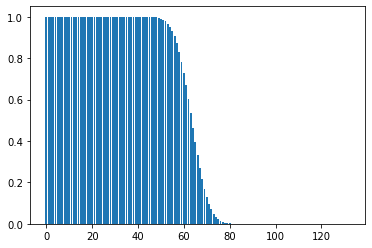

In [208]:
n = 132
k = 132
p = (64/132)

# defining list of r values
r_values = list(range(k + 1))

# list of pmf values
dist = [(1-binom.cdf(r, n, p)) for r in r_values]

# plotting the graph 
plt.bar(r_values, dist)
plt.show()

#### Cumulative Binomial Distribution: step 2

We now find the highest value of $k$ (i.e., $k'$) that keeps the inverse cumulative distribution above a given desired probability $Z$:

\begin{equation}
    k' = argmax_{k\in[0,|TP|]} P(|TP| > k) \geq Z
\end{equation} 

Given a new set of elements (e.g., sentences in a privacy policy) with $E_n$ elements of which $\hat{P}_n$ are predicted as positive by the model. We consider the document to be positive if the threshold, ${Q}=\frac{k'}{E}$ is met, i.e., $\frac{\hat{P}}{E_n} \geq Q$.

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 0.9999999999999999, 20: 0.9999999999999992, 21: 0.9999999999999959, 22: 0.9999999999999803, 23: 0.9999999999999101, 24: 0.99999999999961, 25: 0.9999999999983898, 26: 0.9999999999936638, 27: 0.9999999999762014, 28: 0.999999999914569, 29: 0.999999999706544, 30: 0.9999999990343378, 31: 0.9999999969526671, 32: 0.9999999907688804, 33: 0.9999999731324121, 34: 0.9999999247999454, 35: 0.9999997974296801, 36: 0.9999994744253475, 37: 0.9999986856580106, 38: 0.999996829734865, 39: 0.9999926196165981, 40: 0.9999834068872139, 41: 0.9999639504486865, 42: 0.9999242745740425, 43: 0.9998461169003252, 44: 0.9996973247514301, 45: 0.9994234693976468, 46: 0.998935992859966, 47: 0.9980964838288663, 48: 0.9966973021103668, 49: 0.9944397988334598, 50: 0.9909127819490687, 51: 0.9855754738149037, 52: 0.9777506419802003, 53: 0.9666343437022642, 54: 

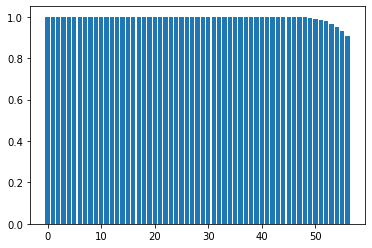

k': 56
P(|TP| > 56): 0.9044595060337591
Threshold value (k'/E): 0.015217391304347827


In [209]:
E_total_elements = 3680
Z = 0.9
n = 132
k = 132
p = (64/132)

# defining list of r values
r_values = list(range(k + 1))

# list of pmf values
dist = [(1-binom.cdf(r, n, p)) for r in r_values]
# k_list = [r for r in r_values if (dist[r] > t)]

k_list = {r:dist[r] for r in r_values if (dist[r] > Z)}

print(k_list)

plt.bar(k_list.keys(), k_list.values())
plt.show()

k_max = max(k_list, key=int)
print("k':", k_max)
print("P(|TP| > " + str(k_max) + "):", k_list[k_max])
print("Threshold value (k'/E):", (k_max/E_total_elements))

Result:
* $k' = 56$
* $P(|TP| > k') = P(|TP| > 56) = 0.904 $

$$ Q = \frac{k'}{E} = \frac{56}{3680} = 0.015217391304347827$$

## Calibrate all thresholds

In [211]:
def calculate_threshold (E_total_elements, Z, n, k, p):
    # defining list of r values
    r_values = list(range(k + 1))
    # list of pmf values
    dist = [(1-binom.cdf(r, n, p)) for r in r_values]

    k_list = {r:dist[r] for r in r_values if (dist[r] > Z)}

#     print(k_list)
#     plt.bar(k_list.keys(), k_list.values())
#     plt.show()

    k_max = max(k_list, key=int)
    print("k':", k_max)
    print("P(|TP| > " + str(k_max) +"):", k_list[k_max])
    print("Threshold value (k'/E):", (k_max/E_total_elements))
    print()
    return (k_max/E_total_elements)

In [216]:
print("DPO")
dpo_threshold = calculate_threshold (3680, 0.9, 132, 132, (64/132))

print("Purpose")
purpose_threshold = calculate_threshold (3680, 0.9, 214, 214, (113/214))

print("Acquired Data")
acquired_data_threshold = calculate_threshold (3680, 0.9, 100, 100, (63/100))

print("Data Sharing")
data_sharing_threshold = calculate_threshold (3680, 0.9, 199, 199, (119/199))

print("Rights")
rights_threshold = calculate_threshold (3680, 0.9, 52, 52, (37/52))
print("")

DPO
k': 56
P(|TP| > 56): 0.9044595060337591
Threshold value (k'/E): 0.015217391304347827

Purpose
k': 103
P(|TP| > 103): 0.9032554361304724
Threshold value (k'/E): 0.02798913043478261

Acquired Data
k': 56
P(|TP| > 56): 0.909912678917289
Threshold value (k'/E): 0.015217391304347827

Data Sharing
k': 109
P(|TP| > 109): 0.9146444361495649
Threshold value (k'/E): 0.029619565217391303

Rights
k': 32
P(|TP| > 32): 0.9133840864630144
Threshold value (k'/E): 0.008695652173913044


